# Adversarial Patch attack

Adversarial patch attack seeks to replace a part of an input image with a patch trained on a variety of images.
This patch is created by replacing part of an image. This involves:
    - creating a patch
    - applying a random translation, scaling and rotation to the patch at a given location. 
    - training the patch to optimize the expected probability of a target class using gradient descent.
  
 The following example demonestrates a white-box adversarial patch attack.

First, install a small utility tool created by Tom Brown [1](https://arxiv.org/pdf/1712.09665.pdf)  

In [ ]:
import sys
!{sys.executable} -m pip install git+https://github.com/nottombrown/imagenet_stubs

Load packages and modules

In [400]:

from __future__ import absolute_import, division, print_function, unicode_literals

import os
import glob
import random
import numpy as np

from PIL import Image
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
from matplotlib import pyplot as plt

import imagenet_stubs
from imagenet_stubs.imagenet_2012_labels import name_to_label
import warnings

from art.classifiers.tensorflow import TFClassifier
from art.attacks import AdversarialPatch


%matplotlib inline
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = [6, 6] # plot size


### Parameters

Conducting a white-box attack involves an adversary with full knowledge of the model's architecture, hyper-parameters, activation function, weights as well as the number of layers.

In [3]:
image_shape = (224, 224, 3)
batch_size = 3
scale_min = 0.3
scale_max = 1.0
rotation_max = 22.5
learning_rate = 200000.0
max_iter = 1000

### Target Class

In [ ]:
target_image_name = 'toaster.jpg'

# Model definition

In [4]:
sess = tf.InteractiveSession()
_image_input = tf.keras.Input(shape=image_shape)
_target_ys = tf.placeholder(tf.float32, shape=(None, 1000))
model = tf.keras.applications.resnet50.ResNet50(input_tensor=_image_input, weights='imagenet')
_logits = model.outputs[0].op.inputs[0]
target_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=_target_ys, logits=_logits))

tfc = TFClassifier(clip_values=(0, 1), input_ph=_image_input, output_ph=_target_ys, logits=_logits,
                   sess=sess, loss=target_loss)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

Instructions for updating:
Use tf.cast instead.


### training images: original

In [333]:

#data_dir ="./images/"
data_dir ="./data/"

images_stack = []

for file in glob.glob(data_dir+"*.jpg"):
    images = image.load_img(file, target_size=(224,224))
    numpy_image = image.img_to_array(images)
    original_img_batch = np.expand_dims(numpy_image, axis=0) 
    images_stack.append(original_img_batch)

concated_images = np.concatenate(images_stack)    

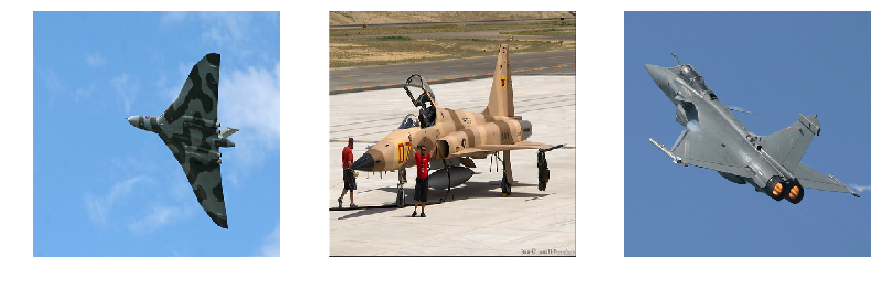

In [337]:
fig=plt.figure(figsize=(28, 28))
w =15
h = 15
columns = 3
rows = 1
for i in range(1, columns*rows +1):
    img = np.random.randint(10, size=(h,w))
    fig.add_subplot(rows, columns, i)
    plt.imshow(np.uint8(concated_images[i-1]))
    plt.axis('off')

plt.show()

### Prepare image for Keras.

Keras expects images to have BRG rather than RGB.

In [338]:
concated_images_for_keras = preprocess_input(concated_image)

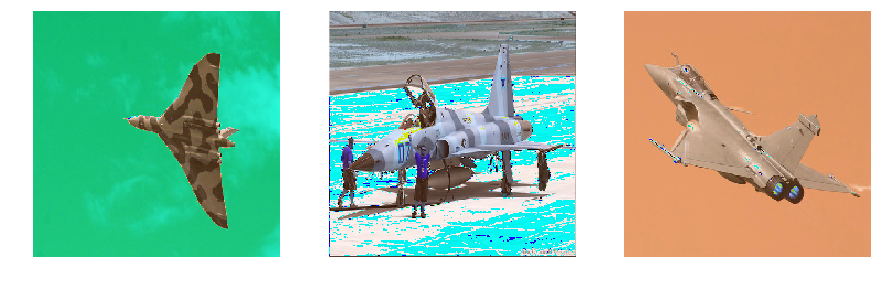

In [341]:
fig=plt.figure(figsize=(28, 28))

for i in range(1, columns*rows +1):
    img = np.random.randint(10, size=(h,w))
    fig.add_subplot(rows, columns, i)
    plt.imshow(np.uint8(concated_images_for_keras[i-1]))
    plt.axis('off')

plt.show()

### Generate Adversarial Patch

In [342]:
ap = AdversarialPatch(classifier=tfc, 
                      target=name_to_label('toaster'), 
                      rotation_max=rotation_max,
                      scale_min=scale_min, 
                      scale_max=scale_max, 
                      learning_rate=learning_rate, 
                      max_iter=max_iter,
                      batch_size=batch_size, 
                      clip_patch=[(-103.939, 255.0 - 103.939), 
                                  (-116.779, 255.0 - 116.779),
                                (-123.680, 255.0 - 123.680)])

patch, patch_mask = ap.generate(x=concated_images_for_keras)

In [343]:
def from_keras(x):
    x = np.copy(x)
    x[:, :, 2] += 123.68
    x[:, :, 1] += 116.779
    x[:, :, 0] += 103.939
    return x[:, :, [2, 1, 0]].astype(np.uint8)

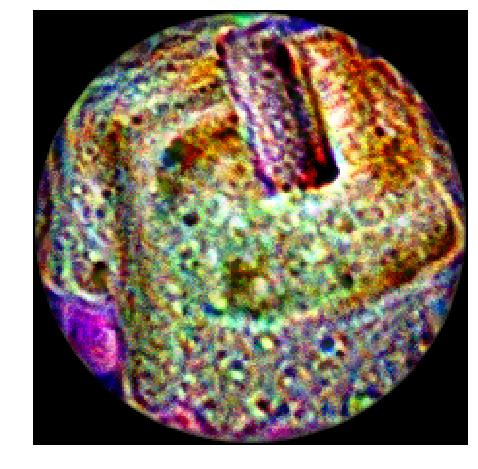

In [344]:
imagenet_patch = (from_keras(patch) * patch_mask).astype(np.uint)
#custom_patch = (from_keras(patch) * patch_mask).astype(np.uint)
plt.imshow(imagenet_patch)
plt.axis('off')
plt.show()

# Evaluation

In [396]:
patched_images = ap.apply_patch(images_for_keras, scale=0.5)

In [403]:
def predict_model(model, image):
    
    predicted_output= from_keras(image)
    new_img_arr = Image.fromarray(predicted_output)
    size = 520, 520
    new_img_arr.thumbnail(size)
    new_img_arr.save('patched_image_3.jpg')
    #save_predicted_output = predicted_output.resize((1920,1080), Image.ANTIALIAS) 
    #plt.imsave('patched_image.jpg',save_predicted_output)
   # predicted_output.save("image_with_patch.jpg")
    plt.imshow(predicted_output.astype(np.uint))
    plt.axis('off')
    plt.show()
    
    image = np.copy(image)
    image = np.expand_dims(image, axis=0)
    image = preprocess_input(image)
    
    prediction = model.predict(image)
    
    top = 3
    prediction_decode = decode_predictions(prediction, top=top)[0]
    print('Predictions:')
    
    lengths = list()
    for i in range(top):
        lengths.append(len(prediction_decode[i][1]))
    max_length = max(lengths)
    
    for i in range(top):
        name = prediction_decode[i][1]
        name = name.ljust(max_length, " ")
        probability = prediction_decode[i][2]
        output_str = "{} {:.2f}".format(name, probability)
        print(output_str)

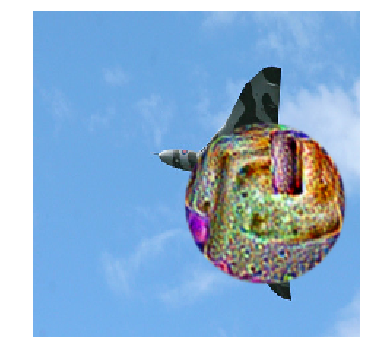

Predictions:
toaster    0.77
piggy_bank 0.18
mask       0.01


In [404]:
ee = predict_model(model, patched_images[0, :, :, :])


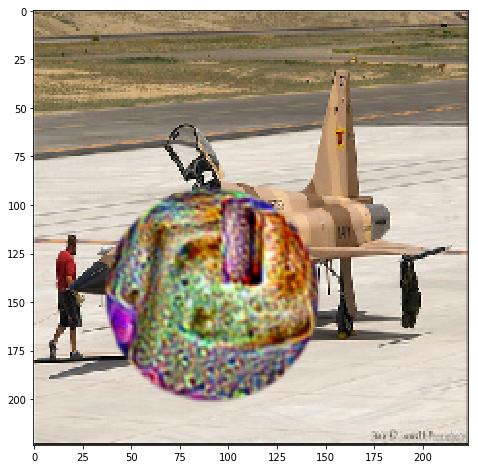

Predictions:
toaster     0.54
dock        0.04
scuba_diver 0.03


In [399]:
predict_model(model, patched_images[1, :, :, :])

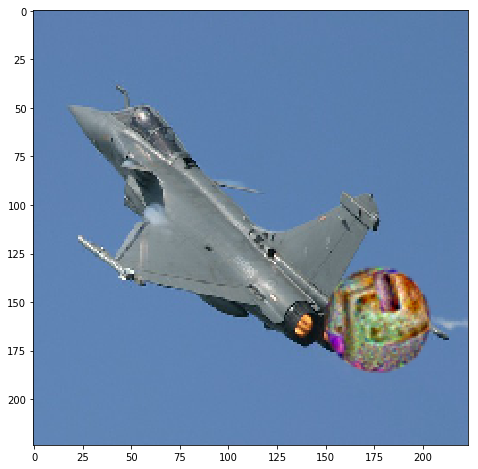

Predictions:
wing      0.33
chain_saw 0.21
warplane  0.19


In [395]:
predict_model(model, patched_images[2, :, :, :])

### Reference

Brown, T., Mane D., Roy A. Abadi M. and Gilmer J. (2017). Adversarial Patch. *31st Conference on Neural Information Processing Systems*. https://arxiv.org/pdf/1712.09665.pdf